# Feature Engineering - Outliers

An outlier is a data point which is significantly different from the remaining data. “An outlier is an observation which deviates so much from the other observations as to arouse suspicions that it was generated by a different mechanism.” [D. Hawkins. Identification of Outliers, Chapman and Hall , 1980.]

#### Should outliers be removed?
Depending on the context, outliers either deserve special attention or should be completely ignored. Take the example of revenue forecasting: if unusual spikes of revenue are observed, it’s probably a good idea to pay extra attention to them and figure out what caused the spike. In the same way, an unusual transaction on a credit card is usually a sign of fraudulent activity, which is what the credit card issuer wants to prevent. So in instances like these, it is useful to look for and investigate further outlier values.

If outliers are however, introduced due to mechanical error, measurement error or anything else that can’t be generalised, it is a good idea to remove these outliers before feeding the data to the modeling algorithm. Why? Because some algorithms are sensitive to outliers.

#### Which machine learning models are sensitive to outliers?
Some machine learning models are more sensitive to outliers than others. For instance, AdaBoost may treat outliers as “hard” cases and put tremendous weights on outliers, therefore producing a model with bad generalisation.

Linear models, in particular Linear Regression, can be also sensitive to outliers.

Decision trees tend to ignore the presence of outliers when creating the branches of their trees. Typically, trees make decisions by asking if variable x >= a certain value, and therefore the outlier will fall on each side of the branch, but it will be treated equally than the remaining values, regardless of its magnitude.

A recent research article suggests that Neural Networks could also be sensitive to outliers, provided the number of outliers is high and the deviation is also high. I would argue that if the number of outliers is high (>15% as suggested in the article), then they are no longer outliers, and rather a fair representation of that variable.

#### How can outliers be identified?
Outlier analysis and anomaly detection is a huge field of research devoted to optimise methods and create new algorithms to reliably identify outliers. There are a huge number of ways to detect outliers in different situations. These are mostly targeted to identify outliers when those are the observations that we indeed want to focus on, for example fraudulent credit card activity.

In this blog we will focus on identifying those outliers introduced by mechanical or measurement error. Those outliers that are indeed a rare case in the population, and that could be ignored. We will see how to identify those outliers.

#### Extreme Value Analysis
The most basic form of outlier detection is Extreme Value Analysis of 1-dimensional data. The key for this method is to determine the statistical tails of the underlying distribution of the variable, and then find the values that sit at the very end of the tails.

If the the variable is Normally distributed (Gaussian), then the values that lie outside the mean plus or minus 3 times the standard deviation of the variable are considered outliers.

 - outliers = mean +/- 3* std

If the distribution of the variable is skewed, a general approach is to calculate the quantiles, and then the inter-quantile range (IQR), as follows:

 - IQR = 75th quantile – 25th quantile

An outlier will sit outside the following upper and lower boundaries:

 - Upper boundary = 75th quantile + (IQR * 1.5)
 - Lower boundary = 25th quantile – (IQR * 1.5)

#### or for extreme cases:

 - Upper boundary = 75th quantile + (IQR * 3)
 - Lower boundary = 25th quantile – (IQR * 3)

#### In this blog
We will:

 - Identify outliers using complete case analysis in Normally distributed variables.
 - Identify outliers using complete case analysis in skewed variables.
 - Datasets for this notebook:
 
In this demo, we will use the House Prices and Titanic datasets.

We will also use the Boston house prices dataset from Scikit-learn.

In [1]:
# to read the dataset into a dataframe and perform operations on it
import pandas as pd

# to perform basic array operations
import numpy as np

# for plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for Q-Q plots
import scipy.stats as stats

# boston house dataset for the demo
from sklearn.datasets import load_boston

We will first load the Boston House price dataset from sklearn. load_boston() loads and returns the boston house-prices dataset. We will see the detailed description of the dataset. DESCR gives the full description of the dataset.

In [2]:
from sklearn.datasets import load_boston
print(load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Now we will create a pandas dataframe which will include the independent variables. We will only use 3 variables RM, LSTAT and CRIM for this demo.

In [3]:
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data,
                      columns=boston_dataset.feature_names)[[
                          'RM', 'LSTAT', 'CRIM'
                      ]]


boston.head()

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


Now we will load two variables Age and Fare from the titanic dataset. The 2 variables have missing values which we will remove for this demo using dropna().

In [4]:
titanic = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/titanic.csv',
                      usecols=['Age', 'Fare'])

titanic.dropna(subset=['Age', 'Fare'], inplace=True)
titanic.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


#### Identify variable distribution
In Normally distributed variables, outliers are those values that lie beyond the mean plus or minus 3 times the standard deviation. If the variables are skewed however, we find outliers using the inter-quantile range. In order to decide which method to utilise to detect outliers, we first need to know the distribution of the variable.

We can use histograms and Q-Q plots to determine if the variable is normally distributed. We can also use boxplots to directly visualise the outliers. Boxplots are a standard way of displaying the distribution of a variable utilising the first quartile, the median, the third quartile and the whiskers.

#### Looking at a boxplot, you can easily identify:

 - The median, indicated by the line within the box.
 - The inter-quantile range (IQR), the box itself.
 - The quantiles, 25th (Q1) is the lower and 75th (Q3) the upper end of the box.
 - The wiskers, which extend to:
     - top whisker: Q3 + 1.5 x IQR 
     - bottom whisker: Q1 -1.5 x IQR
 
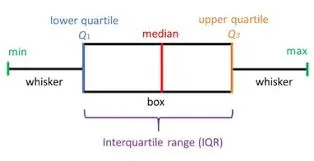

Any value sitting outside the whiskers is considered an outlier. Let’s look at the examples below.

We will create a function diagnostic_plots() which plots the histogram, Q-Q plot and box plot for the specified variable of the given dataframe.

In [5]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title('Histogram')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

#### Normally distributed variables
Let’s start with the variable RM from the boston house dataset. RM is the average number of rooms per dwelling.

/Users/gajendrasahu/opt/anaconda3/envs/tensorflow20/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


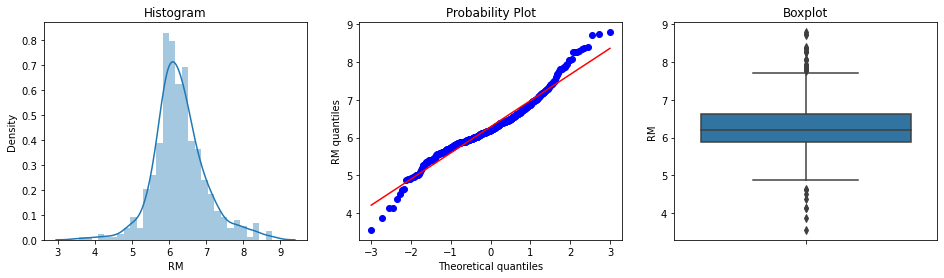

In [6]:
diagnostic_plots(boston, 'RM')


From the histogram and the Q-Q plot, we see that the variable RM approximates a Gaussian distribution quite well. In the boxplot, we see that the variable could have outliers, as there are many dots sitting outside the whiskers, at both tails of the distribution.

Now let’s inspect the variable Age from the titanic dataset. It refers to the age of the passengers on board.

/Users/gajendrasahu/opt/anaconda3/envs/tensorflow20/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


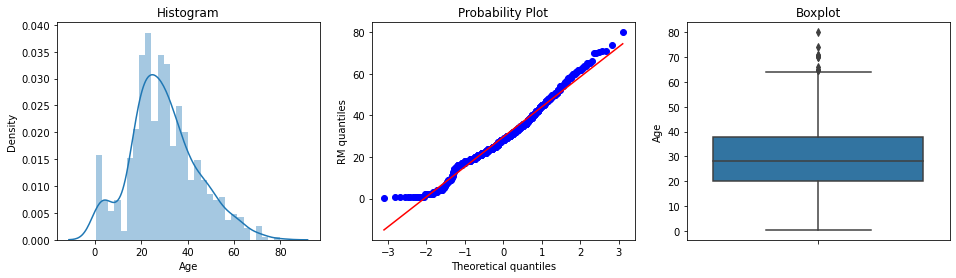

In [7]:
diagnostic_plots(titanic, 'Age')


From the histogram and the Q-Q plot, we see that the variable approximates fairly well a Gaussian distribution. There is a deviation from the distribution towards the smaller values of age. In the boxplot, we can see that the variable could have outliers, as there are many dots sitting outside the whiskers, at the right end of the distribution (top whisker in the boxplot).

#### Skewed variables
Now we will plot the variable LSTAT from the boston house dataset. It gives the % lower status of the population.

/Users/gajendrasahu/opt/anaconda3/envs/tensorflow20/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


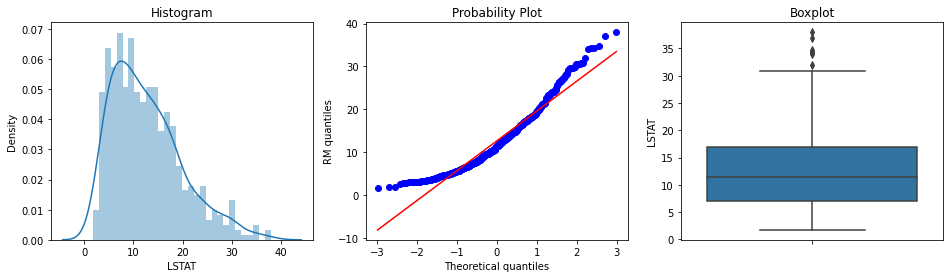

In [8]:
diagnostic_plots(boston, 'LSTAT')

LSTAT is not normally distributed, it is skewed with a tail to the right. According to the boxplot, there are some outliers at the right end of the distribution of the variable.

Let’s see the distribution of the variable CRIM from the boston house dataset. CRIM is the per capita crime rate by town.

/Users/gajendrasahu/opt/anaconda3/envs/tensorflow20/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


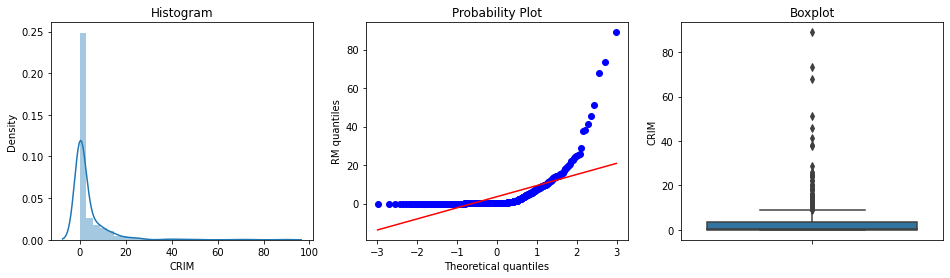

In [9]:
diagnostic_plots(boston, 'CRIM')


CRIM is heavily skewed, with a tail to the right. There seems to be quite a few outliers as well at the right end of the distribution, according to the boxplot.

Now for the variable Fare from the titanic dataset. Fare is the price paid for the ticket by the passengers.

/Users/gajendrasahu/opt/anaconda3/envs/tensorflow20/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


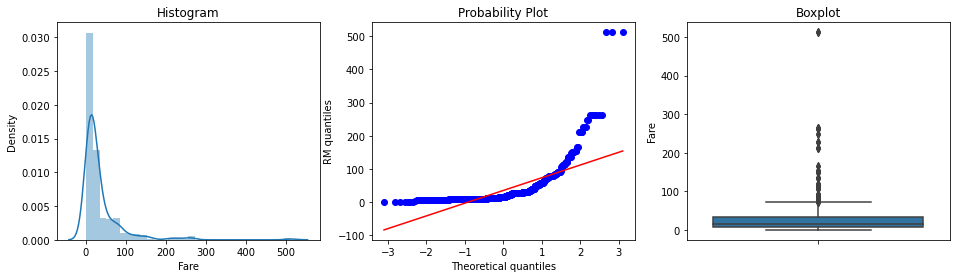

In [10]:
diagnostic_plots(titanic, 'Fare')


Fare is also very skewed, and shows some unusual values at the right end of its distribution.

Now we will identify outliers using the mean and the standard deviation for the variables RM and Age from the boston and titanic datasets respectively. Then we will use the inter-quantile range to identify outliers for the variables LSTAT, CRIM and Fare from the boston and titanic datasets.

#### Outlier detection for Normally distributed variables
We will create a function find_normal_boundaries() which will find the upper and lower boundaries for normally distributed variables.

In [11]:
def find_normal_boundaries(df, variable):

    # calculate the boundaries outside which lie the outliers for a Gaussian distribution

    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

Now we will calculate boundaries for RM using the function created above.



In [12]:
upper_boundary, lower_boundary = find_normal_boundaries(boston, 'RM')
upper_boundary, lower_boundary

(8.392485817597748, 4.176782957105809)

By this we can conclude that values bigger than 8.4 or smaller than 4.2 occur very rarely for the variable RM. Therefore, we can consider them outliers. Now we will inspect the number and percentage of outliers for RM.

In [13]:
print('Total number of houses: {}'.format(len(boston)))

print('Houses with more than 8.4 rooms (right end outliers): {}'.format(
    len(boston[boston['RM'] > upper_boundary])))

print('Houses with less than 4.2 rooms (left end outliers: {}'.format(
    len(boston[boston['RM'] < lower_boundary])))
print()
print('% right end outliers: {}'.format(
    len(boston[boston['RM'] > upper_boundary]) / len(boston)))

print('% left end outliers: {}'.format(
    len(boston[boston['RM'] < lower_boundary]) / len(boston)))

Total number of houses: 506
Houses with more than 8.4 rooms (right end outliers): 4
Houses with less than 4.2 rooms (left end outliers: 4

% right end outliers: 0.007905138339920948
% left end outliers: 0.007905138339920948


Using Extreme Value Analysis we identified outliers at both ends of the distribution of RM. The percentage of outliers is small (1.4% considering the 2 tails together), which makes sense, because we are finding precisely outliers. That is, rare values, rare occurrences.

Let’s move on to Age in the titanic dataset.

In [14]:
# calculate boundaries for Age in the titanic

upper_boundary, lower_boundary = find_normal_boundaries(titanic, 'Age')
upper_boundary, lower_boundary

(73.27860964406094, -13.880374349943303)

The upper boundary is 73 years, which means that passengers older than 73 were very few, if any, in the titanic. The lower boundary is negative. Because negative age does not exist, it only makes sense to look for outliers utilising the upper boundary.

In [15]:
# lets look at the number and percentage of outliers

print('Total passengers: {}'.format(len(titanic)))

print('Passengers older than 73: {}'.format(
    len(titanic[titanic['Age'] > upper_boundary])))
print()
print('% of passengers older than 73: {}'.format(
    len(titanic[titanic['Age'] > upper_boundary]) / len(titanic)))

Total passengers: 714
Passengers older than 73: 2

% of passengers older than 73: 0.0028011204481792717


There were 2 passengers older than 73 on board of the titanic, which could be considered as outliers, because the majority of the population was much younger.

#### Outlier detection for skewed variables
We will create a function find_skewed_boundaries() to find upper and lower boundaries for skewed distributed variables. distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate the boundaries.

In [16]:
def find_skewed_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

We will look for outliers in LSTAT from the boston house dataset using the interquantile proximity rule IQR * 1.5, the standard metric.

In [17]:
upper_boundary, lower_boundary = find_skewed_boundaries(boston, 'LSTAT', 1.5)
upper_boundary, lower_boundary

(31.962500000000006, -8.057500000000005)

Now let’s look at the number and percentage of outliers for LSTAT.



In [18]:
print('Total houses: {}'.format(len(boston)))

print('Houses with LSTAT bigger than 32: {}'.format(
    len(boston[boston['LSTAT'] > upper_boundary])))
print()
print('% of houses with LSTAT bigger than 32: {}'.format(
    len(boston[boston['LSTAT'] > upper_boundary])/len(boston)))

Total houses: 506
Houses with LSTAT bigger than 32: 7

% of houses with LSTAT bigger than 32: 0.01383399209486166


The upper boundary shows a value ~32. The lower boundary is negative, however the variable LSTAT does not take negative values. So to calculate the outliers for LSTAT we will only use the upper boundary. This coincides with what we observed in the boxplot earlier. Outliers sit only at the right tail of LSTAT's distribution.

We observe 7 houses, 1.3 % of the dataset, with extremely high values for LSTAT.

Now we will look for outliers in CRIM using the interquantile proximity rule IQR * 3, now we are looking for extremely high values.

In [19]:
upper_boundary, lower_boundary = find_skewed_boundaries(boston, 'CRIM', 3)
upper_boundary, lower_boundary

(14.462195000000001, -10.7030675)

let’s look at the number and percentage of outliers for CRIM.



In [20]:
print('Total houses: {}'.format(len(boston)))

print('Houses with CRIM bigger than 14: {}'.format(
    len(boston[boston['CRIM'] > upper_boundary])))
print()
print('% of houses with CRIM bigger than 14s: {}'.format(
    len(boston[boston['CRIM'] > upper_boundary]) / len(boston)))

Total houses: 506
Houses with CRIM bigger than 14: 30

% of houses with CRIM bigger than 14s: 0.05928853754940711


While using the 3 times inter-quantile range to find outliers, we find that ~6% of the houses show unusually high crime rate areas. For CRIM as well, the lower boundary is negative, so it only makes sense to use the upper boundary to calculate outliers, as the variable takes only positive values. This coincides with what we observed in CRIM's boxplot earlier in this blog.

Lastly, we will identify outliers in Fare from the titanic dataset. We will look again for extreme values using IQR * 3.

In [21]:
upper_boundary, lower_boundary = find_skewed_boundaries(titanic, 'Fare', 3)
upper_boundary, lower_boundary

(109.35, -67.925)

Let’s look at the number and percentage of passengers who paid extremely high Fares.



In [22]:
print('Total passengers: {}'.format(len(titanic)))

print('Passengers who paid more than 117: {}'.format(
    len(titanic[titanic['Fare'] > upper_boundary])))
print()
print('% of passengers who paid more than 117: {}'.format(
    len(titanic[titanic['Fare'] > upper_boundary])/len(titanic)))

Total passengers: 714
Passengers who paid more than 117: 44

% of passengers who paid more than 117: 0.06162464985994398


For Fare, as well as for all the other variables in this notebook which show a tail to the right, the lower boundary is negative. So we used the upper boundary to determine the outliers. We observe that 6% of the values of the dataset fall above the boundary.

Many machine learning algorithms are sensitive to the range and distribution of attribute values in the input data. Outliers in input data can skew and mislead the training process of machine learning algorithms resulting in longer training times, less accurate models and ultimately poorer results. Even before predictive models are prepared on training data, outliers can result in misleading representations and in turn misleading interpretations of collected data. Outliers can skew the summary distribution of attribute values in descriptive statistics like mean and standard deviation and in plots such as histograms and scatterplots, compressing the body of the data. On the other hand, outliers can represent examples of data instances that are relevant to the problem such as anomalies in the case of fraud detection and computer security.